# Showcase of Bayesian Optimization on mathematical example
## Can be used to compare DoE and Bayesian Optimization approach to modelling or optimization of "black box" function

Datalab has a package called `ProcessOptimizer` installed. It's made for Bayesian optimization of processes such as difficult chemical transformations, fermentations, development of purification methods, baking of brownies, or just about any other case, where a set of input-parameters control a readable output. <br>
<br>
In this notebook, we'll demonstrate how a noisy 7 dimensional (!) mathematical function can be optimized (e.g. we can find the minima) in a limited number of experiments.

First we import the usual suspects:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ProcessOptimizer import Optimizer
from ProcessOptimizer.learning.gaussian_process.kernels import Matern, ConstantKernel
from ProcessOptimizer.learning import cook_estimator
from ProcessOptimizer.plots import plot_objective
from ProcessOptimizer import expected_minimum

np.random.seed(1234)

Before we start with the Bayesian Optimization, we would like to sample the 7d space with a number of random experiments to get a good starting point for the actual optimization. We might want to do this initial screening based on latin hyper cube sampling, so we make a function for that:

In [2]:
def lhssample(n, space):
    x = np.random.uniform(size=[n,len(space)])
    for i in range(0,len(space)):
        x[:,i] = (np.argsort(x[:,i])+0.5)/n
    samples_in_space = x * np.diff(space).T + np.asarray(space).min(axis=1)
    return samples_in_space

We define a given function and apply some noise. <br>
This is function we want to find the minimum of by experimentation:

In [3]:
noise_level = 0.05

def func(x, noise_level=noise_level):
    return -(110 + (np.cos(0.25*x[1])**2) + (np.sin(0.15*x[0])**2) + (0.75 * 0.25 * 0.013 * x[0] * x[1]) + (np.random.randn() * noise_level))

Now, we build the optimizer, we try with a relatively standard kernel for most physical processes (i.e. we load no prior knowledge of radial functions): <br>
For now, please focus primarely on the first line, where the opjective space is defined i.e. we want to find the minimum within these bounds. See also the last line, where the actual optimizer is instantiated. <br>
To apply ProcessOptimizer to any other optimization, we only need to adjust the "space" to fit with the experimental space of the new optimization (whether it be baking brownies or designing rocket science experiments).

In [4]:
space = [(60.0, 85.0), (-5.0, 7.0), (10.0, 12.0), (70.0, 80.0), (40.0, 42.0), (5.8, 8.0), (24.0, 28.0)]

kernel_intern = 1**2 * Matern(length_scale=np.ones(len(space)), length_scale_bounds=[(0.01, 1)], nu=2.5)
base_est = cook_estimator(base_estimator='GP', space=space, noise='gaussian', kernel = kernel_intern) 

opt = Optimizer(space, acq_func="EI", base_estimator=base_est)


Run this cell if you want to perform 19 initial points in a latin hyper cube and report them to the optimizer. <br>
The output of this field is the multidimensional plot of the resulting model:

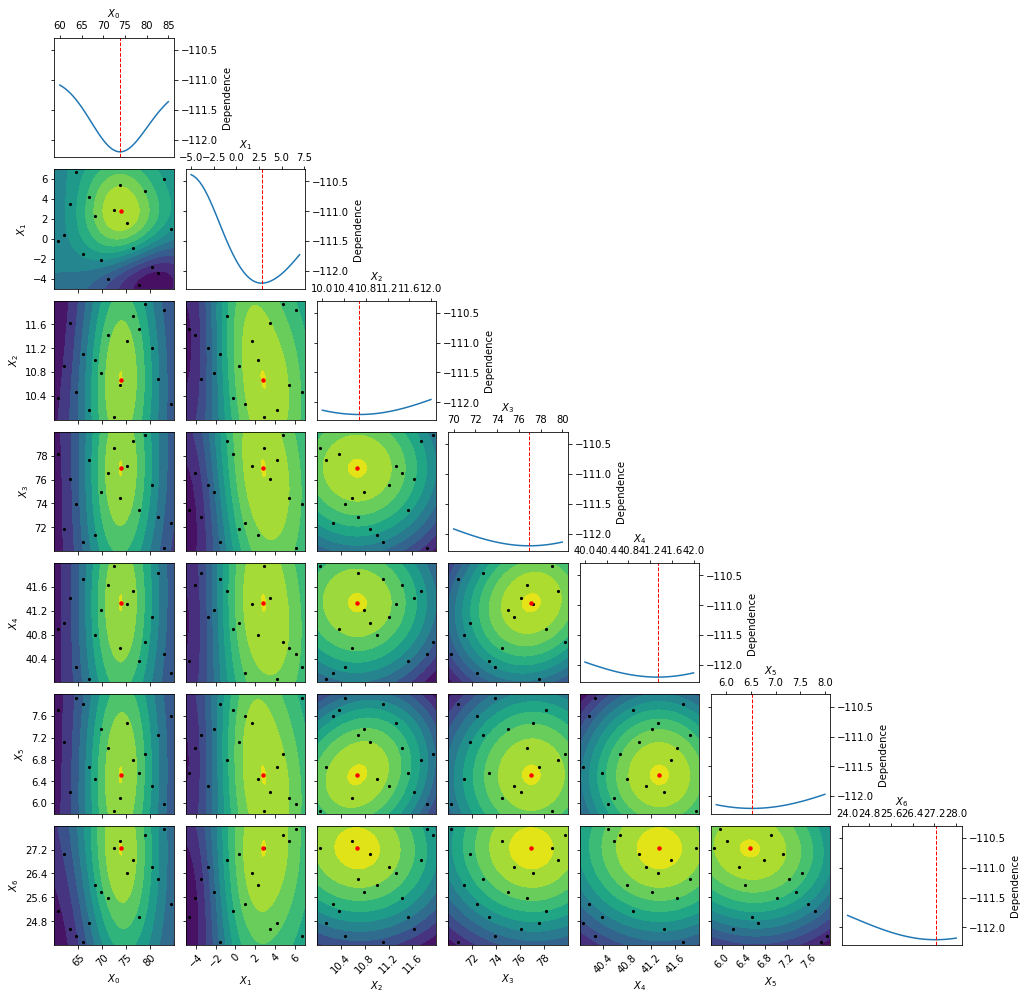

In [5]:
latinhyper_X = lhssample(19, opt.space.bounds)
#print(latinhyperpoints)
latinhyper_y = []
for i in range(len(latinhyper_X)):
    latinhyper_y.append(func(latinhyper_X[i]))


latinhyper_result = opt.tell(latinhyper_X.tolist(), latinhyper_y)
plot_objective(latinhyper_result, usepartialdependence=False, pars='expected_minimum');

Let's look at the fitted parameters/kernel: <br>
The length scale of the individual 7 dimensions can in this example reflect that the model described variance in the output ("the y") by variation in these input dimensions ("the x"). In other words, the model describes variance by altering the two first dimenstions.

In [6]:
print(opt.models[-1].kernel_)

0.823**2 * Matern(length_scale=[0.323, 0.282, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=0)


## That's all good
It seems like the function is only "changing direction" (in lack of better words), when something happens in either of the first two dimensions


We could continue to add points from this point:

To order the recipy for `n` new experiment, the user would write: <br>
`opt.ask(n)` <br>
After performing one of these experiments, we can return to answer to the optimizer as: <br>
`opt.tell(x,y)`


Since this is a mathematical example, we can easily add five experiments:

In [7]:
for i in range(5):
    next_x = opt.ask()
    f_val = func(next_x)
    res = opt.tell(next_x, f_val)

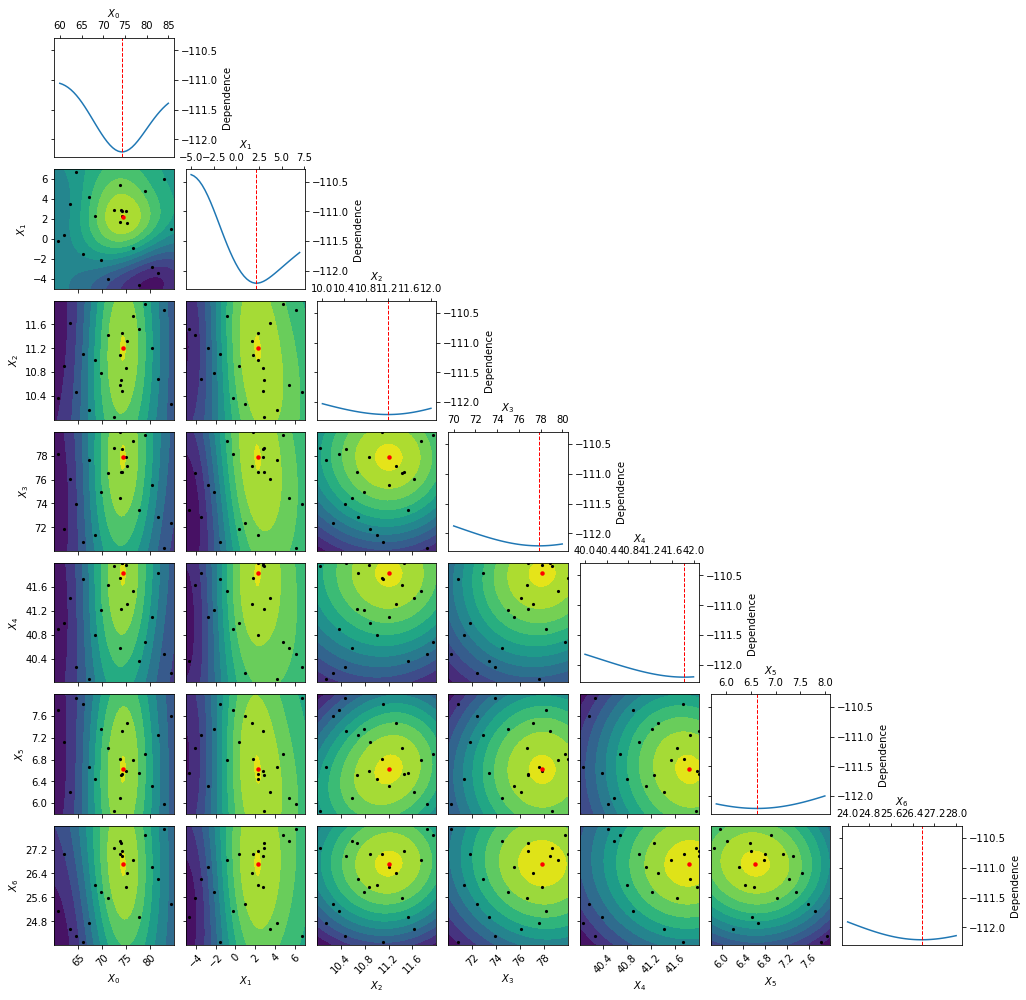

In [8]:
plot_objective(res, usepartialdependence=False, pars='expected_minimum');

The following cells will play with plotting functions. Specifically, it will highlight how the user can control the resolution of the image and then how the user can control the absolute "y-scale" of the 2d plots.

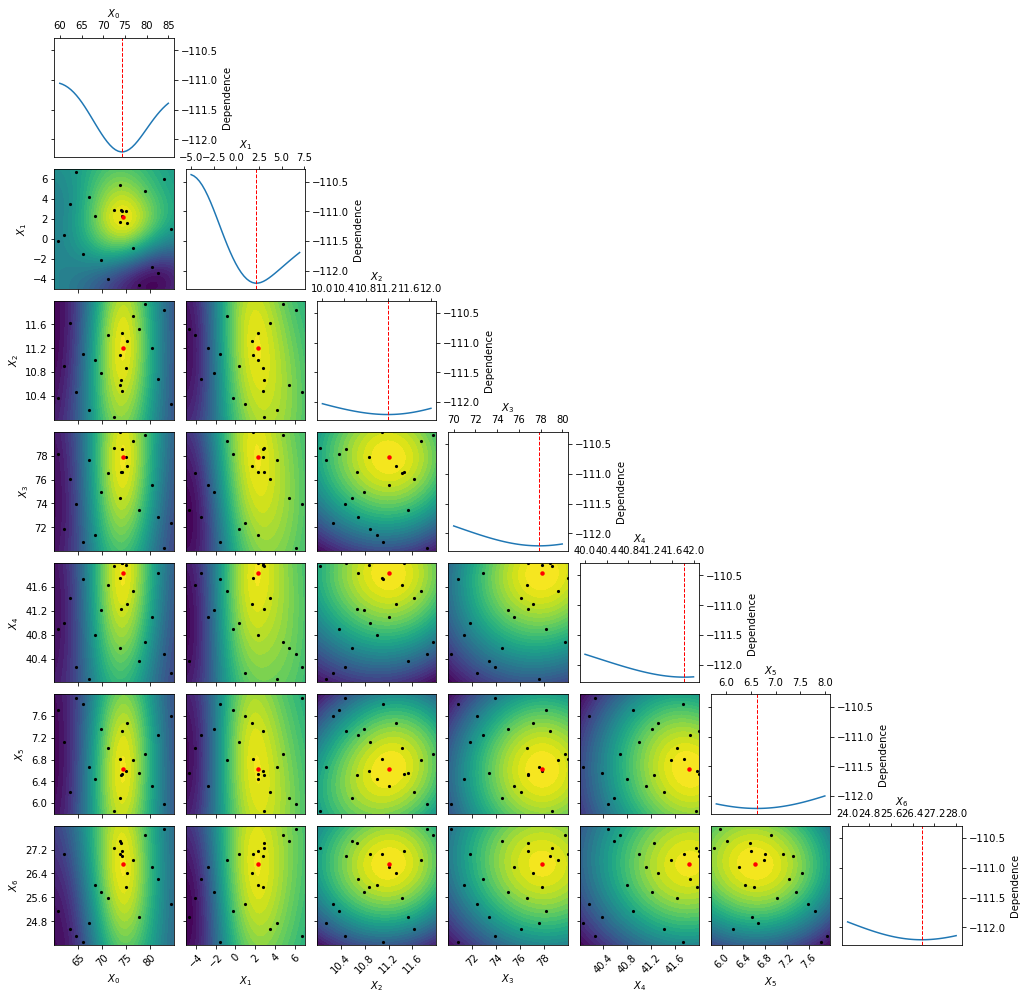

In [9]:
plot_objective(res, levels =35, usepartialdependence=False, pars='expected_minimum');

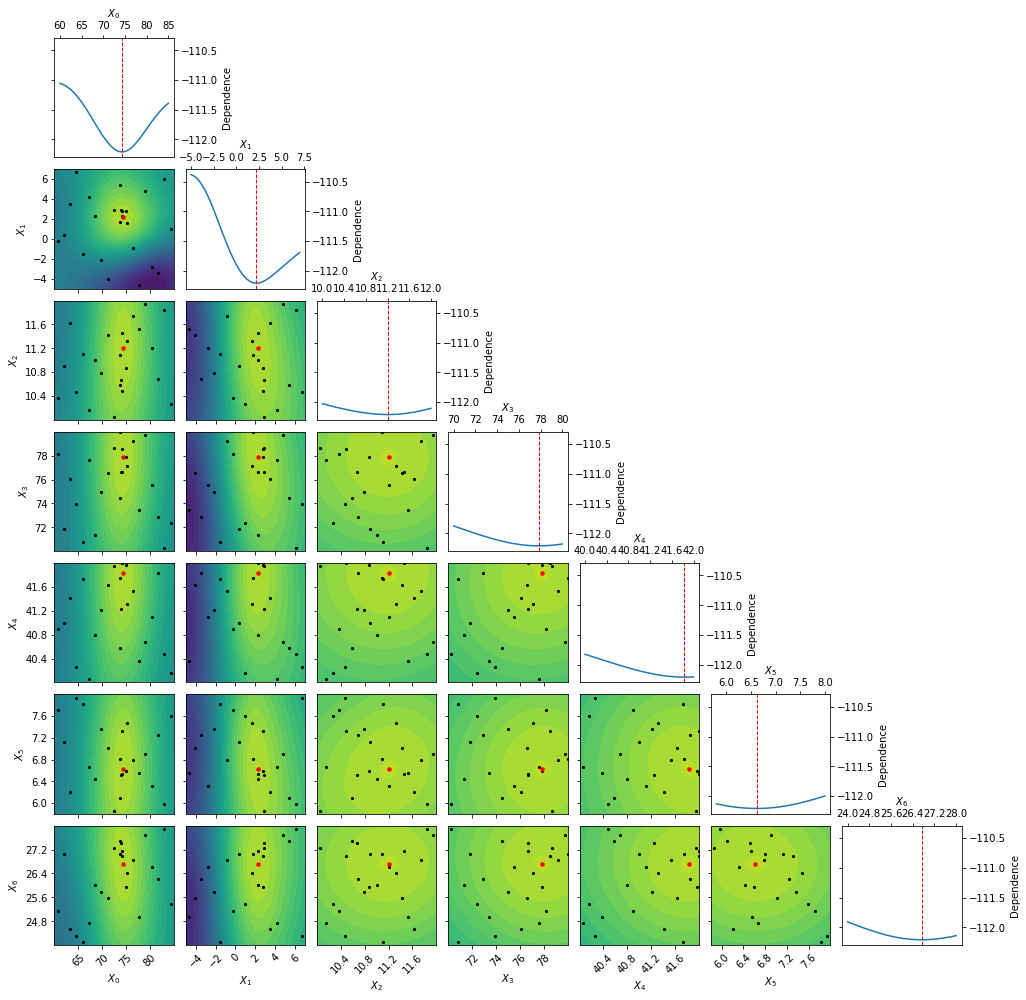

In [10]:
plot_objective(res, levels = np.linspace(-112.5, -110, 35), usepartialdependence=False, pars='expected_minimum');

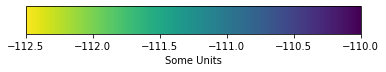

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=-112.5, vmax=-110)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Some Units')
fig.show()

The model is stored in the instantiated optimizer class and can be accessed, if we e.g. want to ask for the expected minimum of the model:

In [12]:
minimum = expected_minimum(res)
minimum_x = [ '%.2f' % elem for elem in minimum[0] ]
minimum_y = round(minimum[1], 2)
print(f'position of expected minimum is {minimum_x} with a expected function value of {minimum_y}!')
print(f'(A "true" value of the noisy evaluation is {round(func(minimum[0]),2)})')

position of expected minimum is ['74.34', '2.22', '11.20', '77.86', '41.83', '6.62', '26.73'] with a expected function value of -112.21!
(A "true" value of the noisy evaluation is -112.09)


Furthermore, we can sample a given point in the 7d landscape for a number of times. This allows us to "simulate" (given that we are satisfied with the model) experiments, and answer questions such as: "how certain are you that the amount of impurity is not greater than x?" (calculated as x= -111.5 in this arbitrary example):

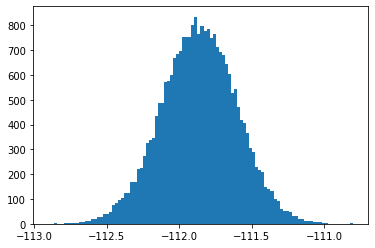

Percentage of bootstrape'd samples at interesting point being less than -111.5 is 91.96


In [13]:
interesting_point = [[72.2, 2.3, 10.0, 77.4, 42.0, 7.1, 25.3],] #given as one entry in a list of lists
transformed_point = opt.space.transform(interesting_point)
samples_of_y = res.models[-1].sample_y(transformed_point, n_samples=25000, random_state=None)
plt.hist(samples_of_y.flatten(), bins=100)
plt.show()
threshold = -111.5
samples_under_threshold = samples_of_y < threshold
percentages = samples_under_threshold.mean()
print(f'Percentage of bootstrape\'d samples at interesting point being less than {threshold} is {percentages*100}')

Hopefully this notebook illustrated some of the usecases for ProcessOptimizer for black box optimization. ProcessOptimizer is an Open Source github repository maintained by Novo Nordisk. Feel free to contribute. <br>
https://github.com/novonordisk-research/ProcessOptimizer


P.S. The sharp reader might have noticed that the mathematical benchmark only have signal in the first two sub-dimensions, which is also found by the optimizer